# 2D Chain Model

In this notebook, we begin to investigate the Anderson model through the simulation of the d= 2
 case.

The Hamiltonian is given by:

$$\hat{H} = \epsilon_0 \delta_{n, m} - t (\delta_{n+1, m} + \delta_{n-1, m})$$

In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import expm

class AndersonLattice:
    '''
    Construct and simulate a 2D Anderson lattice with periodic boundary conditions.
    We represent all wave functions and operators in the lattice site basis. 

    Attributes
        chain (2D ndarray NxN): 
        psi0 (1D ndarray N^2): 
        eps_range (array-like):
        t_hop (float):
        store_history (boolean):
    '''
    def __init__(self, num_sites, psi_0, eps_range, t_hop, store_history=True):
        self.chain = np.zeros((num_sites, num_sites))
        self.num_sites = num_sites
        self.psi_0 = psi_0
        self.eps_range = eps_range
        self.t_hop = t_hop # hopping param
        self.binding = np.diagflat(np.random.uniform(*self.eps_range, size=(self.num_sites**2)))

        if store_history:
            self.history = []

    def _hamiltonian(self):
        '''
        Construct the hamiltonian for the Anderson tight-binding model, a matrix representation in the occupancy site basis. 
        '''
        G = nx.grid_graph(dim = (self.num_sites, self.num_sites), periodic=True)
        A = nx.to_numpy_array(G)
        hopping = -1*self.t_hop * A

        return self.binding + hopping
    
    
    def _time_evolution(self, time):
        '''
        Calculate the unitary time evolution operator for the given hamiltonian.

        Args
            time (float): time when time evolution operator is calculated

        Returns
            U(t) (ndarray of size num_sites x num_sites) 
        '''

        return expm(-1j * self._hamiltonian() * time)
    
    
    def solve(self, t, nt): #t_steps):
        '''
        Calculate psi(t). 

        Args
            t (array-like): time range of form (t_initial, t_final)
            nt (int): number of time steps
        '''        

        times = np.linspace(0, t, nt)
        
        history = []

        for time in times:
            psi_t = self._time_evolution(time) @ self.psi_0
            history.append(psi_t) 
        
        return history
    
    def plotdensity(self, t, axisstabilized = False):
        '''
        Plot the probability density, aka |psi(t)|^2

        Args:
            t (float): time to plot it
        '''

        psi_t = self._time_evolution(t) @ self.psi_0
        density = np.real(np.multiply(psi_t.conj(), psi_t))
        dens2d = np.reshape(density, (self.num_sites, self.num_sites))

        fig = plt.figure(figsize = (12,12))

        ax = plt.axes(projection='3d')
        x = np.arange(0, self.num_sites, 1)
        y = np.arange(0, self.num_sites, 1)
        X, Y = np.meshgrid(x, y)

        surf = ax.plot_surface(X, Y, dens2d, cmap = plt.cm.cividis)

        # Set axes label
        ax.set_xlabel('x', labelpad=20)
        ax.set_ylabel('y', labelpad=20)
        ax.set_zlabel('P', labelpad=20)
        if axisstabilized==True:
            maxy = max(dens2d.flatten())
            ax.set_zlim((0, max(maxy, 0.2)))
        ax.set_title("Wave function probability density at time " + str(t))

        #plt.colorbar(surf)

        plt.show()
        






    

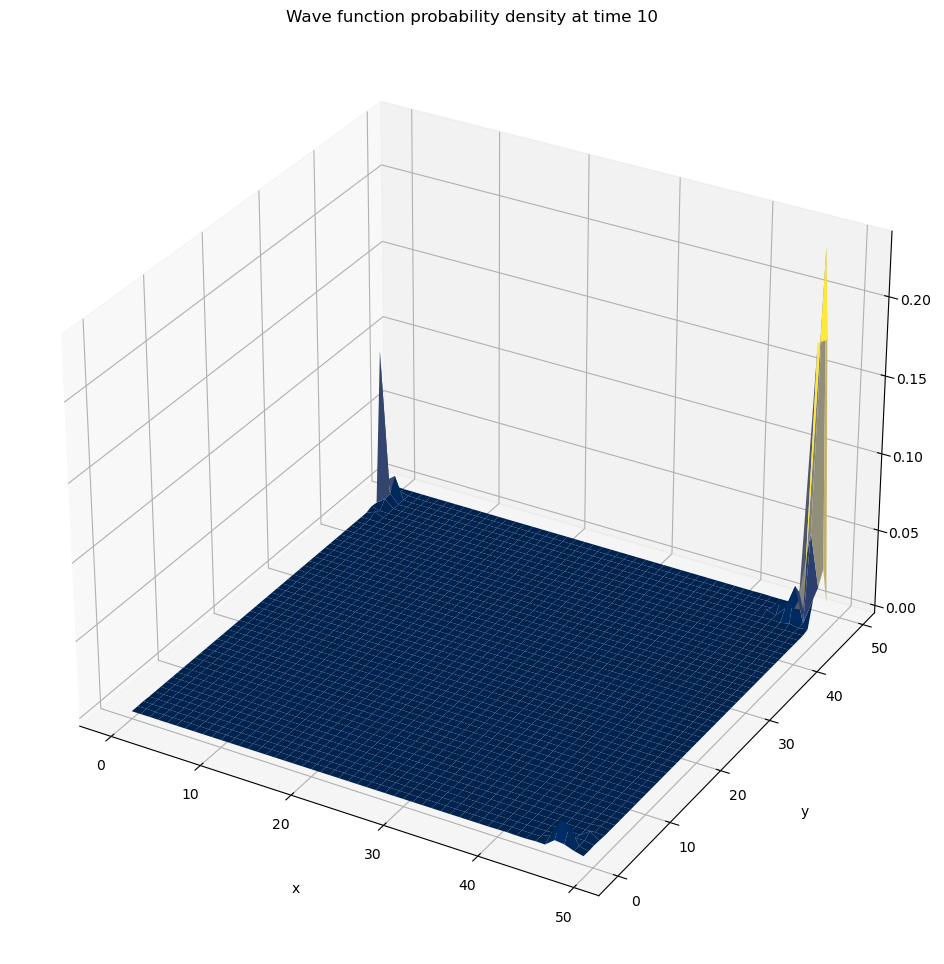

In [16]:

def plotdensityattime(t, n, W, t_hop, psi_0 = 0, axisstabilized = False):
    if psi_0 == 0:
        psi_0 = np.zeros(n**2)
        psi_0[np.random.randint(0, n**2)] = 1
    torus = AndersonLattice(n, psi_0, [-1*W, W], t_hop)
    plotty = torus.plotdensity(10, axisstabilized = axisstabilized)



plotdensityattime(10, 50, 10, 1)

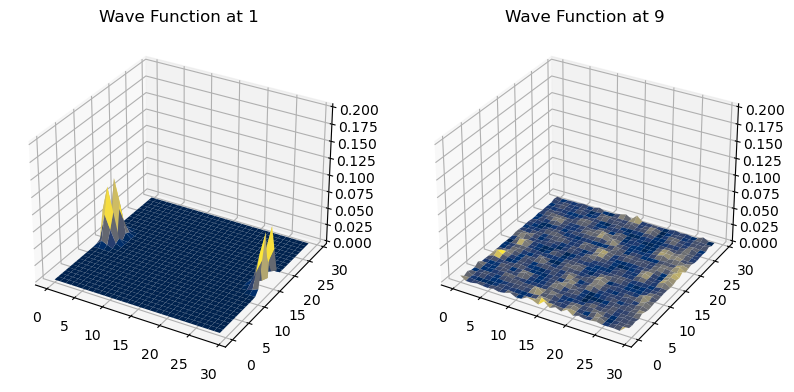

In [134]:

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')

x = np.arange(0, n, 1)
y = np.arange(0, n, 1)
X, Y = np.meshgrid(x, y)
dens1 = (np.real(np.multiply(history[1].conj(), history[1]))).reshape((n, n))
surf = ax.plot_surface(X, Y, dens1, cmap=plt.cm.cividis)
maxy1 = max(dens1.flatten())
ax.set_zlim(0, max(maxy1, 0.2))
ax.set_title("Wave Function at 1")

ax = fig.add_subplot(1, 2, 2, projection='3d')
dens2 = (np.real(np.multiply(history[8].conj(), history[8]))).reshape((n, n))
surf = ax.plot_surface(X, Y, dens2, cmap=plt.cm.cividis)
maxy2 = max(dens2.flatten())
ax.set_zlim(0, max(maxy2, 0.2))
ax.set_title("Wave Function at 9")

plt.show()

In [19]:
from matplotlib.animation import FuncAnimation

n = 100
psi_0 = np.zeros(n**2)
psi_0[np.random.randint(0, n**2)] = 1
torus = AndersonLattice(n, psi_0, [-10, 10], 1)

def lattice3danimation(torus, t_max):
    n = torus.num_sites
    fig = plt.figure(figsize = (12,10))
    plt.style.use('dark_background')
    x = np.arange(0, n, 1)
    y = np.arange(0, n, 1)
    X, Y = np.meshgrid(x, y)
    ax = plt.axes(projection='3d')
    ax.set_xlabel('x', labelpad=20)
    ax.set_ylabel('y', labelpad=20)
    ax.set_zlabel('P', labelpad=20)
    title = 'torusanimation_n_' + str(n) + '_tmax_' + str(t_max)+'.gif'

    def update(frame):
        ax.clear()
        psi_t = torus._time_evolution(frame) @psi_0
        density = np.real(np.multiply(psi_t.conj(), psi_t))
        dens2d = np.reshape(density, (n, n))
        surf = ax.plot_surface(X, Y, dens2d, cmap = plt.cm.cividis)
        ax.set_zlim(0, 1)
        # Set axes label
        ax.set_title("Wave function probability density at time " + str(frame))
    


    ani = FuncAnimation(fig, update, frames=range(0, t_max), interval=100)
    ani.save(title, writer='ffmpeg', fps=5)
    plt.show()


lattice3danimation(torus, 20)
    

MovieWriter ffmpeg unavailable; using Pillow instead.


In [ ]:
n = 30
psi_0 = np.zeros(n**2)
psi_0[np.random.randint(0, n**2)] = 1
torus = AndersonLattice(n, psi_0, [-10, 10], 1)

def latticeheatmapanimation(torus, t_max):
    n = torus.num_sites 
    fig, ax = plt.subplots(figsize = (12,10))

    im = ax.imshow(np.zeros((n, n)), cmap="cividis", vmin=0, vmax = 1)
    cb = plt.colorbar(im, ax=ax)
    cb.set_label('Probability Density')
    plt.style.use('dark_background')
    title = 'torusheatmap_n_' + str(n) + '_tmax_' + str(t_max)+'.gif'

    def update(frame):
        ax.clear()
        psi_t = torus._time_evolution(frame) @ psi_0
        density = np.real(np.multiply(psi_t.conj(), psi_t))
        dens2d = np.reshape(density, (n, n))
        im = ax.imshow(dens2d, cmap="cividis")
        ax.set_title("Wave function probability density at time " + str(frame))
    

    ani = FuncAnimation(fig, update, frames=range(0, t_max), interval=100)
    ani.save(title, writer='ffmpeg', fps=5)
    plt.show()

latticeheatmapanimation(torus, 10)